<a href="https://colab.research.google.com/github/oscarserc/TESIS_Transformers/blob/main/Practica_a__Transformer_Encoder_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning

In [ ]:

import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader


In [ ]:

# DEFINIMOS LA CLASE QUE CONVIERTE LOS DATOS QUE ENVIAMOS (en un DATAFRAME) en TENSORES
# =====================================================================================

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X.iloc[ix]).float(), torch.tensor(self.y.iloc[ix]).long()


# DEFINIMOS LA CLASE PARA PODER ITERAR POR BATCHES
# ================================================

class MNISTDataModule(pl.LightningDataModule):
  def __init__(self, batch_size: int = 64, Dataset = Dataset ):
    super().__init__()
    self.batch_size = batch_size
    self.Dataset = Dataset

  def setup(self, stage=None):
    mnist = fetch_openml('mnist_784', version=1)
    X, y = mnist['data'], mnist['target']
    X_train, X_test = X[:60000] / 255., X[60000:] / 255.
    y_train, y_test = y[:60000].astype(np.int), y[60000:].astype(np.int)
    self.train_ds   = self.Dataset(X_train, y_train)
    self.val_ds     = self.Dataset(X_test, y_test)

  def train_dataloader(self):
    return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return DataLoader(self.val_ds, batch_size=self.batch_size,)    


In [ ]:

dm_mnist = MNISTDataModule()
dm_mnist.setup()

imgs, labels = next(iter(dm_mnist.train_dataloader()))
imgs.shape, labels.shape


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(torch.Size([64, 784]), torch.Size([64]))

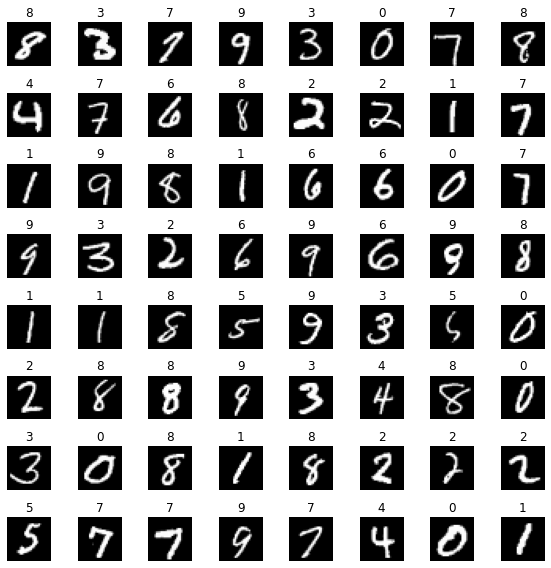

In [ ]:

r, c = 8, 8
fig = plt.figure(figsize=(c,r))
for _r in range(r):
  for _c in range(c):
    ix = _r*c + _c
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.axis('off')
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_title(label.item())
plt.tight_layout()
plt.show()    


# **AHORA PASAMOS A CONSTRUIR EL MODELO CON pl.LightningModule**

In [ ]:

class MLP(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(784, 784),
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(784, 10)
    )

  def forward(self, x):
    return self.mlp(x)

  def predict(self, x):
    with torch.no_grad():
      y_hat = self(x)
      return torch.argmax(y_hat, axis=1)

  def compute_loss_and_acc(self, batch):
    x, y = batch
    y_hat = self(x)
    loss  = F.cross_entropy(y_hat, y)
    acc   = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
    return loss, acc

  def training_step(self, batch, batch_idx):
    loss, acc = self.compute_loss_and_acc(batch)
    self.log('loss', loss)
    self.log('acc', acc, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    loss, acc = self.compute_loss_and_acc(batch)
    self.log('loss', loss)
    self.log('acc', acc, prog_bar=True)        
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.0003)
    return optimizer  


In [ ]:

mlp = MLP()
salidas = mlp(torch.randn(64, 784))
salidas.shape


torch.Size([64, 10])

In [ ]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=2, gpus=0, logger=None)
trainer.fit(mlp, dm_mnist)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 623 K 
------------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.493     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

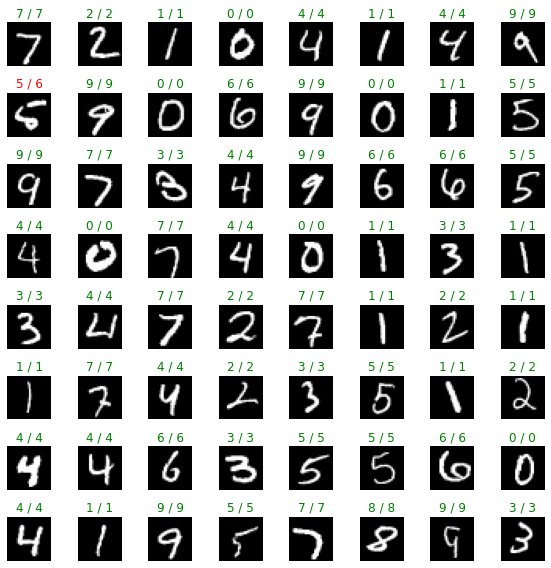

In [ ]:

imgs, labels = next(iter(dm_mnist.val_dataloader()))
predicciones = mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(c,r))
for _r in range(r):
  for _c in range(c):
    ix = _r*c + _c
    ax = plt.subplot(r, c, ix + 1)
    img, label = imgs[ix], labels[ix]
    ax.axis('off')
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_title(f'{label.item()} / {predicciones[ix].item()}', color='green' if label == predicciones[ix] else 'red')
plt.tight_layout()
plt.show()    


# **AHORA RESOLVEMOS EL MISMO PROBLEMA CON UN TRANSFORMER**

In [ ]:

class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X.iloc[ix]).float().view(28,28)
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w)
    patches = patches.contiguous().view(-1, h*w)
    return patches, torch.tensor(self.y.iloc[ix]).long()    



In [ ]:

# PROBAMOS A VER CÓMO CIRCULAN LOS DATOS
# --------------------------------------

attn_dm_mnist = MNISTDataModule(Dataset = AttnDataset)
attn_dm_mnist.setup()

imgs, labels = next(iter(attn_dm_mnist.train_dataloader()))
imgs.shape, labels.shape


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(torch.Size([64, 16, 49]), torch.Size([64]))

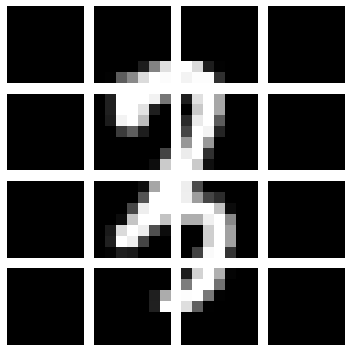

In [ ]:

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(4):
  for j in range(4):
    ax = plt.subplot(4, 4, i*4 + j + 1)
    ax.imshow(imgs[6, i*4 + j].view(7,7), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()    



# **PASAMOS A CONSTRUIR EL MODELO TRANSFORMER implementando cada una de sus partes**

In [ ]:

import math

# BLOQUE MULTIHEAD-ATTENTION
# --------------------------

class MultiHeadAttention(torch.nn.Module):
  def __init__(self, n_embd, n_heads):
    super().__init__()
    self.n_heads = n_heads

    # KEY, QUERY y VALUE proyecciones
    self.key   = torch.nn.Linear(n_embd, n_embd*n_heads)
    self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
    self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

    # PROYECCIÓN de SALIDA
    self.proj  = torch.nn.Linear(n_embd*n_heads, n_embd)

  def forward(self, x):
    B, L, F = x.size()

    # PROCEDEMOS A CALCULAR TODOS LOS VALORES EN LAS CABEZAS
    k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3)
    q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3)
    v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3)

    # APLICAMOS EL MECANISMO DE ATENCIÓN
    att = (q @ k.transpose(-2, -1))*(1.0 / math.sqrt(k.size(-1)))
    att = torch.nn.functional.softmax(att, dim=-1)
    y = att @ v
    y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads)

    return self.proj(y)


# BLOQUE TRANSFORMER
# ------------------    
class TransformerBlock(torch.nn.Module):
  def __init__(self, n_embd, n_heads):
    super().__init__()
    self.ln1  = torch.nn.LayerNorm(n_embd)
    self.ln2  = torch.nn.LayerNorm(n_embd)
    self.attn = MultiHeadAttention(n_embd, n_heads)
    self.mlp  = torch.nn.Sequential(
        torch.nn.Linear(n_embd, 4*n_embd),
        torch.nn.ReLU(),
        torch.nn.Linear(4*n_embd, n_embd)
    )

  def forward(self, x):
    x = self.ln1(x + self.attn(x))
    x = self.ln2(x + self.mlp(x))
    return x  


# MODELO
# ======
class Model(MLP):
  def __init__(self, n_input=7*7, n_embd=7*7, seq_len=4*4, n_heads=4*4, n_layers=1):
    super().__init__()
    self.mlp = None
    self.pos_emb = torch.nn.Parameter(torch.zeros(1, seq_len, n_embd))
    self.inp_emb = torch.nn.Linear(n_input, n_embd)
    self.transformer = torch.nn.Sequential(*[TransformerBlock(n_embd, n_heads) for _ in range(n_layers)])
    self.fc = torch.nn.Linear(n_embd*seq_len, 10)

  def forward(self, x):
    # EMBEDDING
    e = self.inp_emb(x) + self.pos_emb
    # Bloque TRANSFORMER
    x = self.transformer(e)
    # CLASIFICADOR
    y = self.fc(x.view(x.size(0), -1))
    return y  



In [ ]:

modelo = Model(n_layers=3)
trainer = pl.Trainer(max_epochs=2, gpus=0, logger=None)
trainer.fit(modelo, attn_dm_mnist)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name        | Type       | Params
-------------------------------------------
0 | inp_emb     | Linear     | 2.5 K 
1 | transformer | Sequential | 527 K 
2 | fc          | Linear     | 7.9 K 
-------------------------------------------
538 K     Trainable params
0         Non-trainable params
538 K     Total params
2.153     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_wa

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

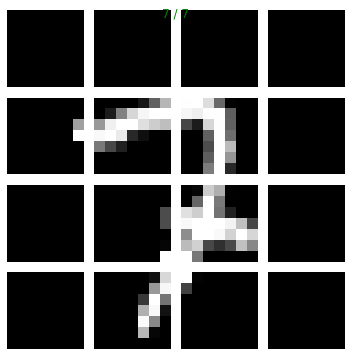

In [ ]:

import random

attn_imgs, attn_labels = next(iter(attn_dm_mnist.val_dataloader()))
predicciones = modelo.predict(attn_imgs)

ix = random.randint(0, attn_dm_mnist.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(4):
  for j in range(4):
    ax = plt.subplot(4, 4, i*4 + j + 1)
    ax.imshow(attn_imgs[ix, i*4 + j].view(7,7), cmap='gray')
    ax.axis('off')
fig.suptitle(f'{attn_labels[ix]} / {predicciones[ix].item()}', color='green' if attn_labels[ix] == predicciones[ix].item() else 'red')    
plt.tight_layout()
plt.show()

